<div id="toc"></div>

---

{{< pagebreak >}}

# Objetivo

Implementação de uma rede neural de duas camadas com capacidade para a resolução de problemas não-lineares e estudar os efeitos da regularização sobre o desempenho do modelo.

# Execução

## Definição de Extreme Learning Machines (ELM)

$$
\textbf{X}_{(N, n)} \xrightarrow{\textbf{Z}_{n, p}} \textbf{H}_{(n, p)} \xrightarrow{\textbf{w}_{(p, 1)}} y_{(N, 1)}
$$

Um conjunto de variáveis de entrada ($\textbf{X}$) com $N$ amostras e $n$ características é transformado por uma matriz ($\textbf{Z}$) aleatória com que mapeia, de forma não linear, a informação de entrada em um novo espaço expandido com $p$ características. O resultado final é calculado a partir da combinação da informação gerada nesse novo espaço ($\textbf{H}$) disponível na camada escondida da rede com os pesos associados a cada neurônio, dados pesos estimados em função da informação a ser prevista ($y$).

## Bibliotecas relevantes para o código

In [376]:
from tqdm import tqdm
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split

---

{{< pagebreak >}}

## Geração de dados sintéticos

In [377]:
std_dev = 1.2
n_samples = 100

* `std_dev`: variância da distribuição dos dados do problema de separação não linear
* `n_samples`: número de observações para cada grupo de observações gerado aleatoriamente

### Geração de classes para problemas de separação não-lineares

In [378]:
class_0 = np.vstack([
    (np.random.normal(size=(n_samples, 2), scale=std_dev)
     + np.tile([2, 2], n_samples).reshape(-1, 2)),
    (np.random.normal(size=(n_samples, 2), scale=std_dev)
     - np.tile([2, 2], n_samples).reshape(-1, 2))
])

class_1 = np.vstack([
    (np.random.normal(size=(n_samples, 2), scale=std_dev)
     + np.tile([2, -2], n_samples).reshape(-1, 2)),
    (np.random.normal(size=(n_samples, 2), scale=std_dev)
     + np.tile([-2, 2], n_samples).reshape(-1, 2))
])

data = np.vstack([class_0, class_1])
target = np.repeat([-1, 1], repeats=n_samples * 2).reshape(-1, 1)
data.shape, target.shape

((400, 2), (400, 1))

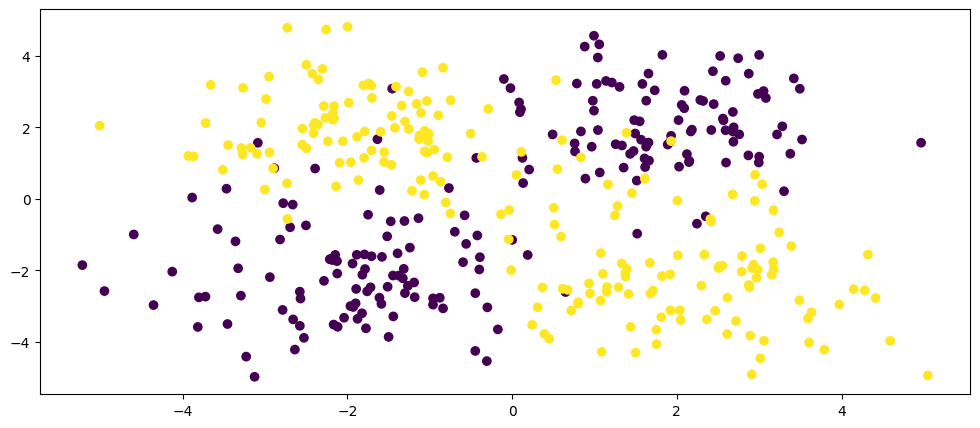

In [379]:
#| echo: false

plt.figure(figsize=(12, 5))
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

O resultado da geração sintética de dados apresenta um problema de classificação binária não linearmente separável com leve interseção. Tal conjunto de dados será útil para testar o comportamento da rede ELM em diversos cenários de ajuste.

---

{{< pagebreak >}}

**Construção de grade de avaliação**

A grade de avaliação é necessária para desenhar a superfície de separação entre as classes

In [380]:
steps = 100

grid_x0 = np.linspace(
    start=np.floor(np.min(data[:, 0])),
    stop=np.ceil(np.max(data[:, 0])),
    num=steps
)
grid_x1 = np.linspace(
    start=np.floor(np.min(data[:, 1])),
    stop=np.ceil(np.max(data[:, 1])),
    num=steps
)
grid = np.array([[x0, x1] for x0 in grid_x0 for x1 in grid_x1])
grid.shape

(10000, 2)

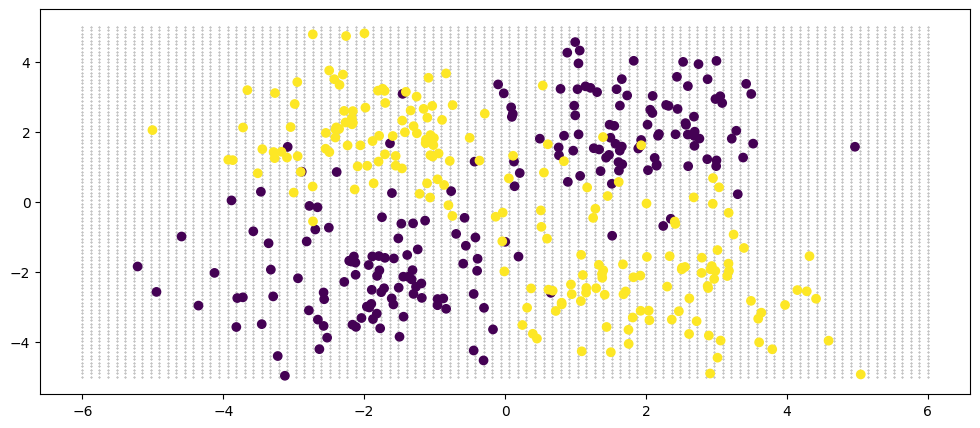

In [381]:
#| echo: false

plt.figure(figsize=(12, 5))
plt.scatter(grid[:, 0], grid[:, 1], color='black', alpha=.5, s=.1)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

---

{{< pagebreak >}}

## Exercício ELM Clássica

Nesta seção será implementado passo a passo o algoritmo da rede ELM identificando as dimensões de cada matriz gerada em cada passo para garantir a corretude das operações.

**Especificação de parâmetros**

In [382]:
neurons_hidden = 10
neurons_output = 1

**Camada de Entrada:** geração de pesos aleatórios

In [383]:
input_weights = np.random.uniform(size=(data.shape[1] + 1, neurons_hidden))
input_weights.shape

(3, 10)

**Camada Escondida:** transformação da entrada com função de ativação não linear

In [384]:
hidden_input = (
    np.hstack([np.ones(shape=(data.shape[0], 1)), data])
    @ input_weights
)
hidden_input.shape

(400, 10)

In [385]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([np.ones(shape=(data.shape[0], 1)), hidden_output])
hidden_output.shape

(400, 11)

**Camada de Saída:** cálculo de pesos da camada de saída

In [386]:
output_weights = np.linalg.pinv(hidden_output) @ target
output_weights.shape

(11, 1)

**Camada de Saída:** cálculo dos valores de saída da rede

In [387]:
output_input = hidden_output @ output_weights
output_input.shape

(400, 1)

A função de ativação do neurônio de saída é linear, portanto o valor de entrada do neurônio é igual ao valor de saída

In [388]:
output_output = output_input * 1

**Avaliação de resultados da classificação**

In [389]:
#| echo: false

print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.79      0.83      0.81       200
        True       0.83      0.78      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



Nota-se resultados com qualidade aceitável para a avaliação do dado de treinamento quando considerado um número pequeno de neurônios na camada escondida.

---

{{< pagebreak >}}

## Modelo Classificador ELM

Para facilitar o uso do modelo construído, foi feita uma classe seguindo os padrões da biblioteca Scikit-Learn para o modelo ELM

In [390]:
class ELMClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, neurons: int):
        self.neurons = neurons

    def fit(self, X, y):
        # GENERATE RANDOM HIDDEN LAYER WEIGHTS
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # CALCULATE OUTPUT LAYER WEIGHTS
        self.w_output_ = np.linalg.pinv(hidden_output) @ y

        return self

    def predict(self, X):
        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # CALCULATE OUTPUT LAYER INPUT VALUES
        output_input = hidden_output @ self.w_output_

        # OUTPUT LAYER ACTIVATEION FUNCTION IS LINEAR
        return output_input.reshape(-1, 1)

**Avaliação do `ELMClassifier`**

In [391]:
(
    data_train, data_test, target_train, target_test
) = train_test_split(data, target, test_size=.3)

In [392]:
model = ELMClassifier(neurons=10)
model.fit(data_train, target_train)
preds = model.predict(data_test)
print(classification_report(y_pred=preds > 0, y_true=target_test > 0))

              precision    recall  f1-score   support

       False       0.82      0.85      0.84        60
        True       0.84      0.82      0.83        60

    accuracy                           0.83       120
   macro avg       0.83      0.83      0.83       120
weighted avg       0.83      0.83      0.83       120



Nota-se resultados com qualidade aceitável para a avaliação do dado de teste quando considerado um número pequeno de neurônios na camada escondida.

---

{{< pagebreak >}}

**Teste com múltiplos números de neurônios na camada escondida**

Para avaliar em qual situação o modelo é melhor dimensionado em relação ao número de neurônios na camada escondida, vários números serão considerados para teste. Aquele valor que apresentar o maior ganho de qualidade da predição com o menor número de neurônios representa o número de neurônios mais apropriado para o problema em questão.

In [393]:
res = list()
for i in range(2, 100):
    model = ELMClassifier(neurons=i)
    model.fit(data_train, target_train)
    preds = model.predict(data_test)
    res.append({
        'neurons': i,
        'report': classification_report(
            y_pred=preds > 0,
            y_true=target_test > 0,
            output_dict=True
        )
    })
df_res = pd.json_normalize(res)

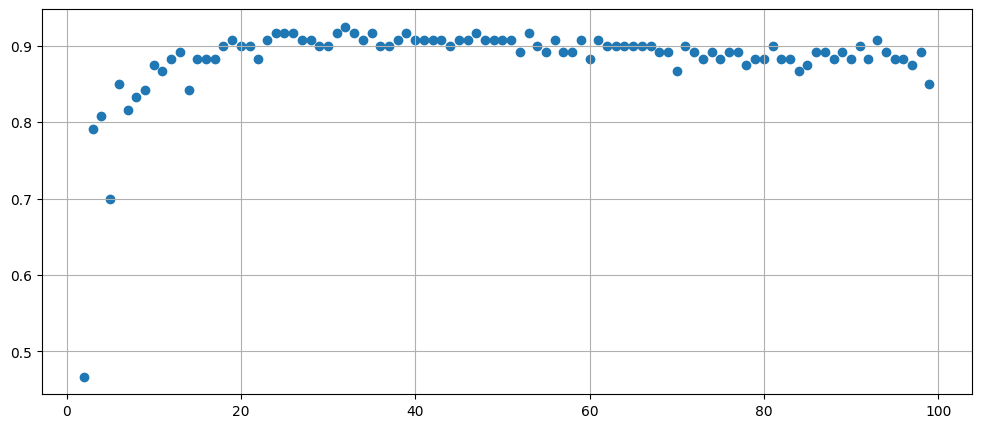

In [394]:
#| echo: false

plt.figure(figsize=(12, 5))
plt.scatter(df_res['neurons'], df_res['report.accuracy'])
plt.grid()
plt.show()
plt.close()

A partir do gráfico acima, nota-se que o número ótimo de neurônios na camada escondida está, aproximadamente, entre 15 e 25.

---

{{< pagebreak >}}

**Avaliação de modelo bem ajustado**

In [395]:
model = ELMClassifier(neurons=15)
model.fit(data, target)
preds = model.predict(grid)

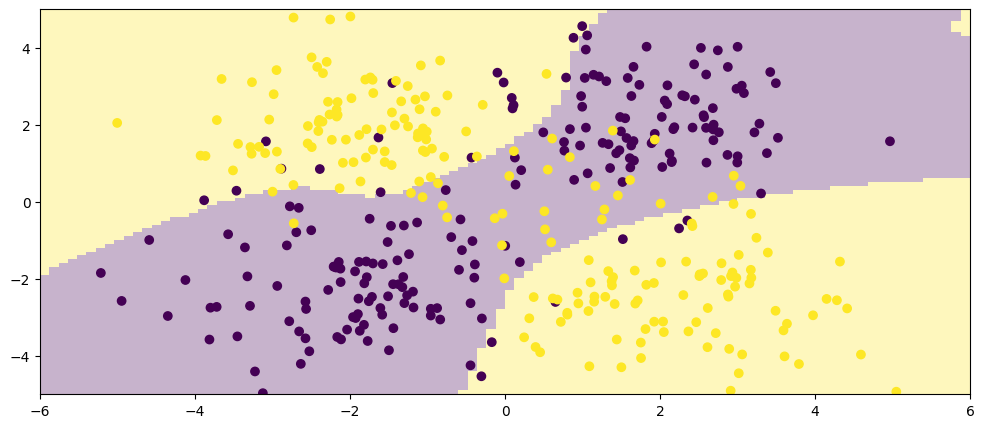

In [396]:
#| echo: false

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3, aspect='auto'
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

Nota-se no gráfico acima que a superfície de separação é razoavelmente suave representando bem o que poderia ser a margem de separação real do problema.

---

{{< pagebreak >}}

**Avaliação de modelo sobre-ajustado**

In [397]:
model = ELMClassifier(neurons=256)
model.fit(data, target)
preds = model.predict(grid)

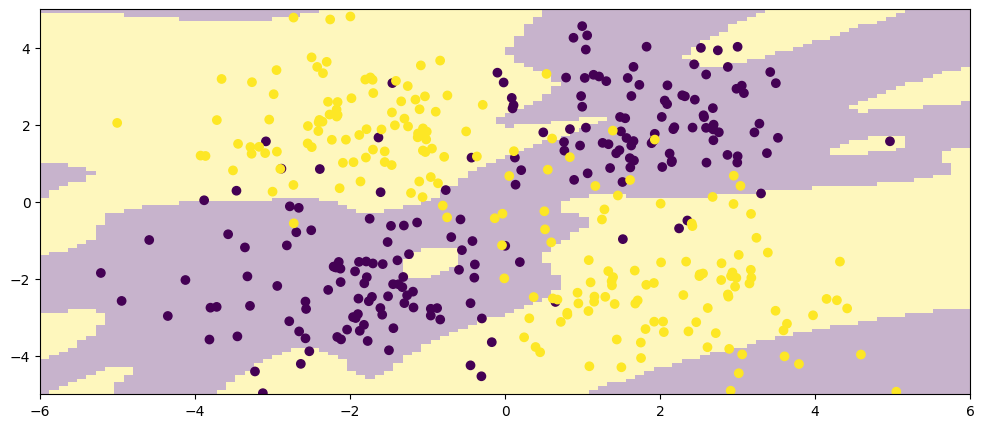

In [398]:
#| echo: false

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3, aspect='auto'
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

No caso em que o modelo é ajustado com alto número de neurônios na camada escondida o resultado se torna visivelmente sobre-ajustado. A superfície de separação apresentada no gráfico acima não apresenta transições suaves e se altera consideravelmente para ajustar o máximo possível a cada uma das observações do dado.

---

{{< pagebreak >}}

## Exercício ELM com Regularização

Dada a situação em que o número de neurônios é elevado e o modelo sobre-ajusta aos dados disponíveis é possível adicionar uma operação de regularização da rede para evitar tal comportamento.

Nesta seção será implementado passo a passo o algoritmo da rede ELM com regularização e sem regularização identificando as dimensões de cada matriz gerada em cada passo para garantir a corretude das operações.

**Especificação de parâmetros**

In [399]:
neurons_hidden = 256
neurons_output = 1

**Camada de Entrada:** geração de pesos aleatórios

In [400]:
input_weights = np.random.uniform(size=(data.shape[1] + 1, neurons_hidden))
input_weights.shape

(3, 256)

**Camada Escondida:** transformação da entrada com função de ativação não linear

In [401]:
hidden_input = (
    np.hstack([np.ones(shape=(data.shape[0], 1)), data])
    @ input_weights
)
hidden_input.shape

(400, 256)

In [402]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([np.ones(shape=(data.shape[0], 1)), hidden_output])
hidden_output.shape

(400, 257)

**Camada de Saída:** cálculo de pesos da camada de saída com adição de regularização

$$
w = (\textbf{H}^T\textbf{H} + \lambda \textbf{I}_p)^{-1} \textbf{H}^T \textbf{y}
$$

**Avaliação do Modelo:** com regularização nula

In [403]:
reg = 0

aux = np.linalg.pinv(
    (hidden_output.T @ hidden_output)
    + (reg * np.identity(neurons_hidden + 1))
)
output_weights = aux @ hidden_output.T @ target
output_input = hidden_output @ output_weights
output_output = output_input * 1

print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.95      0.96      0.96       200
        True       0.96      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



No caso de treinamento do modelo sem regularização, mas com quantidade considerável de neurônios na camada escondida: nota-se na tabela acima um ajuste aos dados bastante próximo de 100% de acurácia o que sugere uma situação de sobre-ajuste.

**Avaliação do Modelo:** com regularização não nula arbitrária

In [406]:
reg = 1e3

aux = np.linalg.pinv(
    (hidden_output.T @ hidden_output)
    + (reg * np.identity(neurons_hidden + 1))
)
output_weights = aux @ hidden_output.T @ target
output_input = hidden_output @ output_weights
output_output = output_input * 1

print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.86      0.73      0.79       200
        True       0.77      0.89      0.82       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



Quando adicionado um valor considerável de regularização as métricas de qualidade da predição para o conjunto de teste reduzem consideravelmente em comparação com a avaliação sem regularização. Tal mudança sugere que a superfície de separação não mais está sobre-ajustando aos dados o que da indícios de que a metodologia de regularização é válida.

---

{{< pagebreak >}}

### Modelo Classificador ELM

In [350]:
class ELMClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, neurons: int, reg: float = 0.0):
        self.neurons = neurons
        self.reg = reg

    def fit(self, X, y):
        # GENERATE RANDOM HIDDEN LAYER WEIGHTS
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # CALCULATE OUTPUT LAYER WEIGHTS
        aux = np.linalg.pinv(
            (hidden_output.T @ hidden_output)
            + (self.reg * np.identity(self.neurons + 1))
        )
        self.w_output_ = aux @ hidden_output.T @ y

        return self

    def predict(self, X):
        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # CALCULATE OUTPUT LAYER INPUT VALUES
        output_input = hidden_output @ self.w_output_

        # OUTPUT LAYER ACTIVATEION FUNCTION IS LINEAR
        return output_input.reshape(-1, 1) > 0

**Avaliação de modelo bem ajustado**

In [351]:
model = ELMClassifier(neurons=15)
model.fit(data, target)
preds = model.predict(grid)

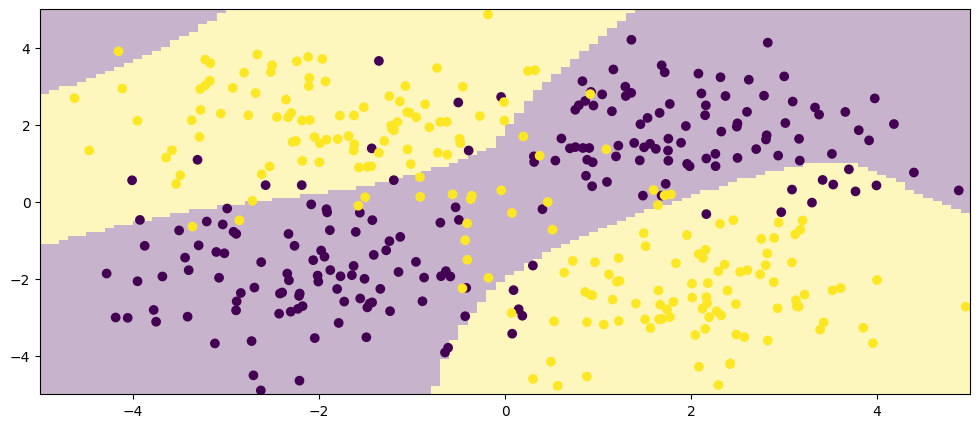

In [352]:
#| echo: false

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.imshow(
    (~preds > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3, aspect='auto'
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

**Avaliação de modelo sobre-ajustado**

In [353]:
model = ELMClassifier(neurons=100)
model.fit(data, target)
preds = model.predict(grid)

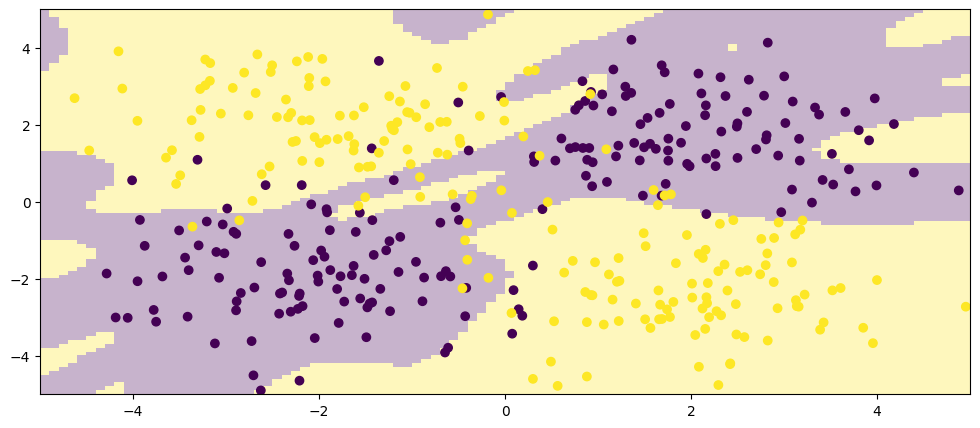

In [354]:
#| echo: false

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.imshow(
    (~preds > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3, aspect='auto'
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

**Avaliação de modelo sobre-ajustado com regularização**

In [355]:
model = ELMClassifier(neurons=100, reg=1)
model.fit(data, target)
preds = model.predict(grid)

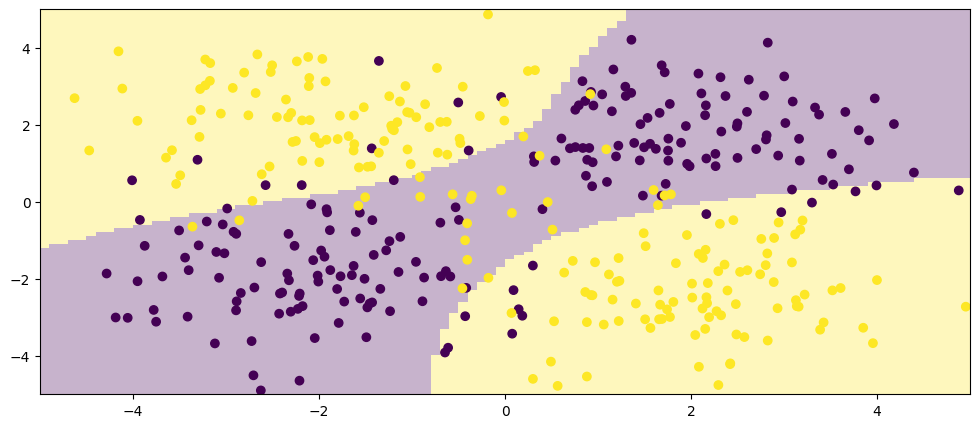

In [356]:
#| echo: false

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.imshow(
    (~preds > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3, aspect='auto'
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

Nota-se pelos últimos 3 gráficos apresentados que o modelo sobre-ajustado quando adicionada a regularização se aproxima de um modelo com baixo número de neurônios e de melhor ajuste aos dados.

---

{{< pagebreak >}}

## Exercício ELM com Regularização em Dados Reais

* **Dataset selecionado:** [Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29) (January 8, 1991)

* **Descrição das colunas de características disponíveis:**

n  |Attribute                    |Domain
:--|:----------------------------|:----------
 1.|Sample code number           |id number
 2.|Clump Thickness              |1 - 10
 3.|Uniformity of Cell Size      |1 - 10
 4.|Uniformity of Cell Shape     |1 - 10
 5.|Marginal Adhesion            |1 - 10
 6.|Single Epithelial Cell Size  |1 - 10
 7.|Bare Nuclei                  |1 - 10
 8.|Bland Chromatin              |1 - 10
 9.|Normal Nucleoli              |1 - 10
10.|Mitoses                      |1 - 10
11.|Class:                       |(2 for benign, 4 for malignant)

* **Proporção das Classes:**

Classe   | Proporção
---------|-----------
Benign   |458 (65.5%)
Malignant|241 (34.5%)

In [357]:
from io import StringIO

url = (
    'https://archive.ics.uci.edu/ml/'
    + 'machine-learning-databases/'
    + 'breast-cancer-wisconsin/'
    + 'breast-cancer-wisconsin.data'
)
response = requests.get(url)
df = pd.read_csv(StringIO(response.content.decode('utf-8')), header=None)

**Pre-processamento**

In [358]:
df = (
    df
    .replace('?', np.nan)
    .astype('float')
    .dropna()
)

In [359]:
df[df[10] == 2].shape, df[df[10] == 4].shape

((444, 11), (239, 11))

In [360]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1:]
y = ((y / 2) - 1) * 2 -1

X.shape, y.shape

((683, 9), (683, 1))

In [361]:
(
    X_train, X_test, y_train, y_test
) = train_test_split(X.values, y.values, test_size=.3)

In [362]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

In [363]:
from sklearn.model_selection import LeaveOneOut, cross_validate

In [364]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ELMClassifier(neurons=300, reg=0))
])

In [365]:
res = list()
for i in tqdm(range(10, 200, 5)):
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('model', ELMClassifier(neurons=i, reg=0))
    ])

    pipe.fit(X_train, y_train)

    res.append({
        'neurons': i,
        'accuracy_train': np.mean(pipe.predict(X_train) == (y_train > 0)),
        'accuracy_test': np.mean(pipe.predict(X_test) == (y_test > 0))
    })

df_res = pd.json_normalize(res)

100%|██████████| 38/38 [00:00<00:00, 72.41it/s] 


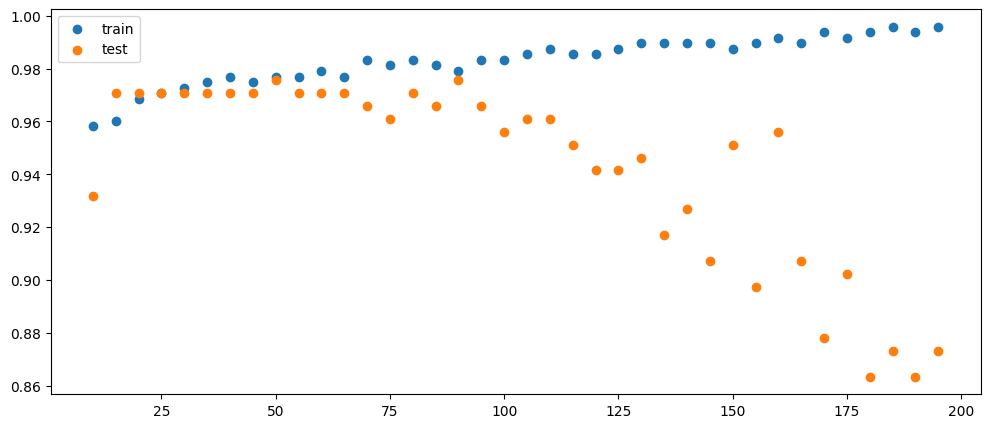

In [366]:
plt.figure(figsize=(12, 5))
plt.scatter(df_res['neurons'], df_res['accuracy_train'], label='train')
plt.scatter(df_res['neurons'], df_res['accuracy_test'], label='test')
plt.legend()
plt.show()
plt.close()

No caso representado acima para a avaliação do modelo em um conjunto de testes separado do conjunto de treinamento nota-se que com o aumento do número de neurônios na camada escondida a qualidade da predição do conjunto de teste reduz. Vale mencionar também que o valor da métrica de qualidade da previsão do conjunto de treinamento aumenta com o aumento do número de neurônios. Tal comportamento é claramente uma representação de uma situação de sobre-ajuste.

Nesse caso a rede foi treinada com o parâmetro de regularização zerado para não gerar efeito de regularização no resultado.

In [367]:
res = list()
for i in tqdm(range(10, 200, 5)):
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('model', ELMClassifier(neurons=i, reg=1e3))
    ])

    pipe.fit(X_train, y_train)

    res.append({
        'neurons': i,
        'accuracy_train': np.mean(pipe.predict(X_train) == (y_train > 0)),
        'accuracy_test': np.mean(pipe.predict(X_test) == (y_test > 0))
    })

df_res = pd.json_normalize(res)

100%|██████████| 38/38 [00:00<00:00, 60.38it/s]


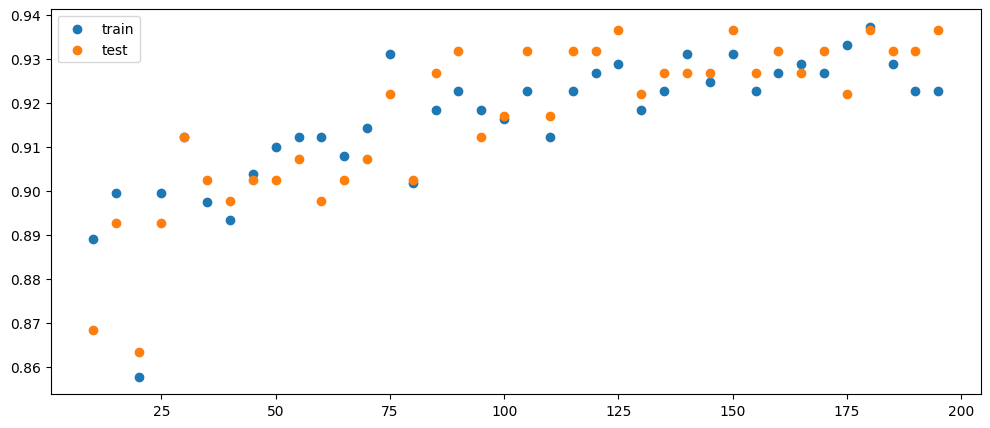

In [368]:
plt.figure(figsize=(12, 5))
plt.scatter(df_res['neurons'], df_res['accuracy_train'], label='train')
plt.scatter(df_res['neurons'], df_res['accuracy_test'], label='test')
plt.legend()
plt.show()
plt.close()

Ao definir um valor arbitrário para o parâmetro de regularização o resultado fica bastante diferente do cenário anterior. No cenário com regularização ambas as métricas de avaliação da previsão do modelo para o conjunto de treino e teste aumentam com o aumento do número de neurônios. Assim não existe sobre-ajuste ao conjunto de dados de treinamento em detrimento do conjunto de dados de teste.

Pode-se dizer que a estratégia de regularização empregada é bastante eficiente para controle de sobre-ajuste de modelos ELM.

---